In [2]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd

In [3]:
df = pd.read_csv('final_depression_dataset_1.csv')

# Preprocessing and Encoding

In [5]:
# 1. Label Encoding for Binary Features (Yes/No, Gender)
le = LabelEncoder()
binary_cols = ['Gender', 'Have you ever had suicidal thoughts ?',
               'Family History of Mental Illness', 'Depression']

for col in binary_cols:
    df[col] = le.fit_transform(df[col].astype(str))

# 2. One-Hot Encoding for Multiclass Features (Profession, Sleep, Diet)
# We drop 'Name' and 'City' to reduce noise and dimensionality
df_ml = df.drop(columns=['Name', 'City', 'Degree'])
df_ml = pd.get_dummies(df_ml, columns=['Working Professional or Student', 'Profession',
                                       'Sleep Duration', 'Dietary Habits'], drop_first=True)

# Fill remaining NaNs from the Professional/Student split with 0
df_ml = df_ml.fillna(0)

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Define X (features) and y (target)
X = df_ml.drop('Depression', axis=1)
y = df_ml['Depression']

# Split into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# **Random Forest (Robustness)**

Random Forest is ideal for identifying non-linear relationships between lifestyle factors and mental health.

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Initialize with 'balanced' weights to handle the lower frequency of depression cases
rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf_model.fit(X_train, y_train)

# Evaluation
y_pred_rf = rf_model.predict(X_test)
print("Random Forest Report:\n", classification_report(y_test, y_pred_rf))

Random Forest Report:
               precision    recall  f1-score   support

           0       0.95      0.99      0.97       421
           1       0.93      0.74      0.82        91

    accuracy                           0.94       512
   macro avg       0.94      0.86      0.89       512
weighted avg       0.94      0.94      0.94       512



# **Logistic Regression (Interpretability)**

For mHealth apps, Logistic Regression is valuable because it provides a probability score (e.g., "70% risk") rather than just a Yes/No answer.

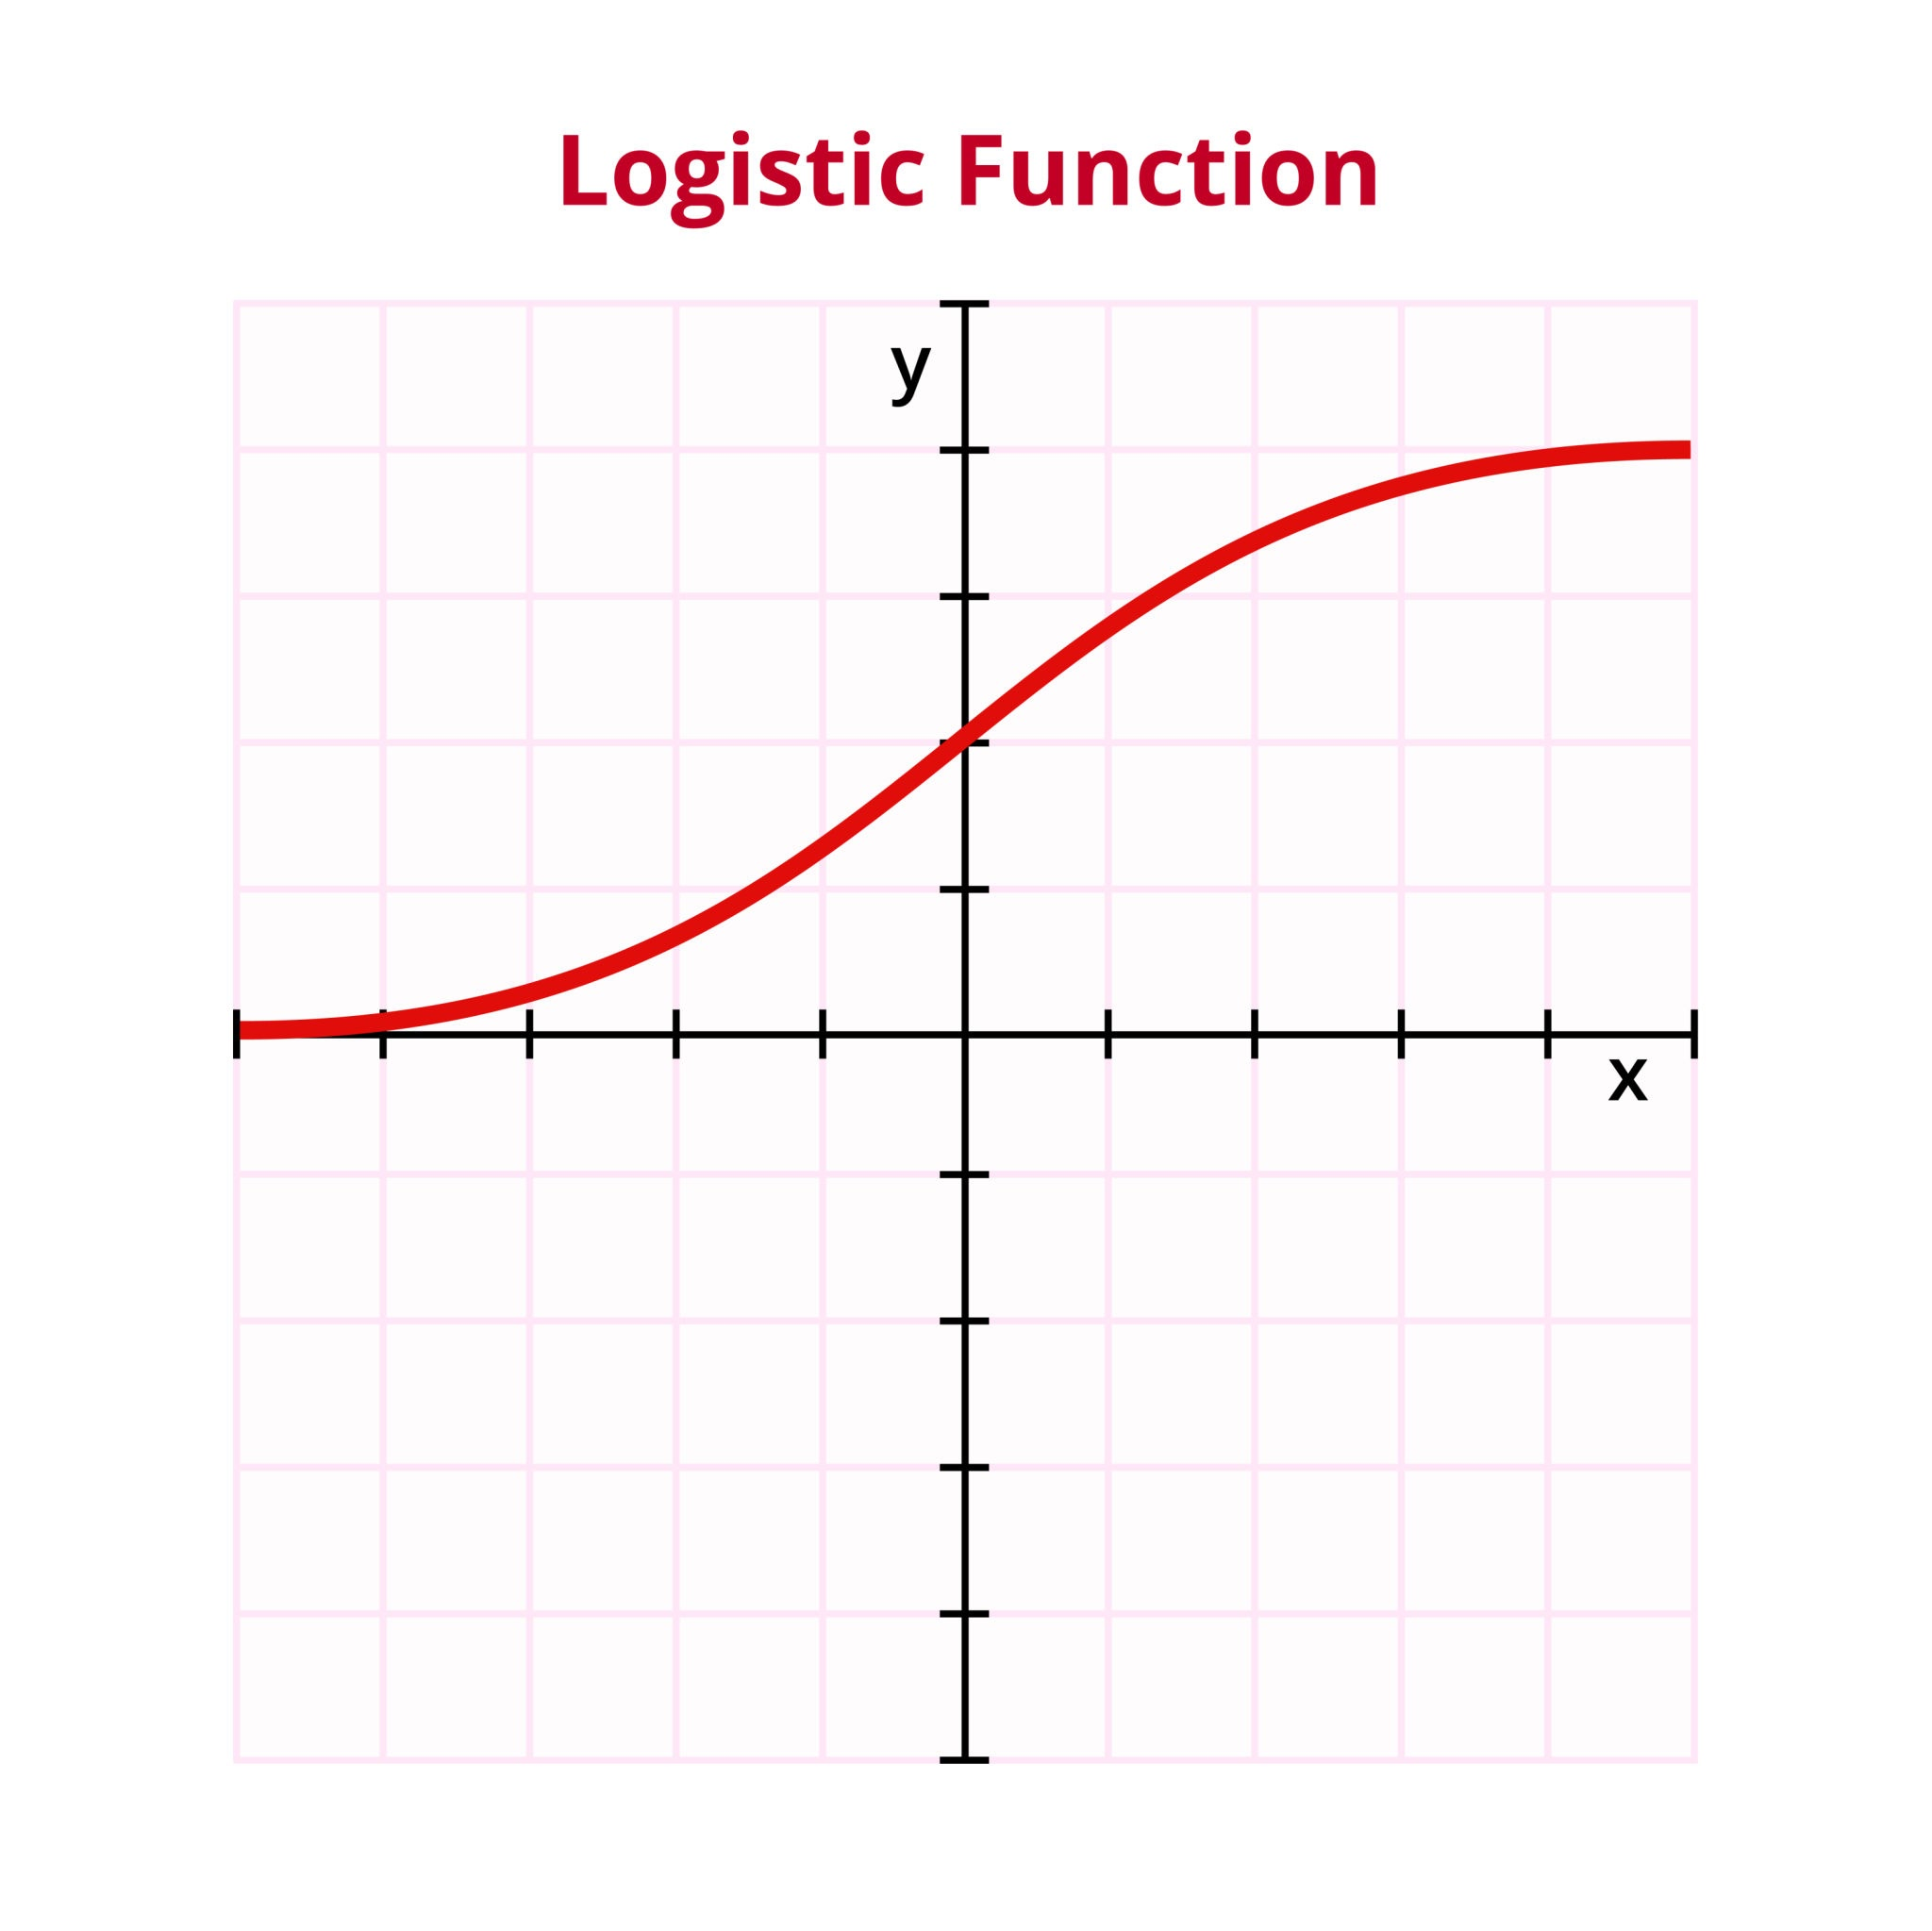

In [8]:
from sklearn.linear_model import LogisticRegression

# Logistic Regression works best on the 'scaled' data
lr_model = LogisticRegression(class_weight='balanced', max_iter=1000)
lr_model.fit(X_train_scaled, y_train)

# Evaluation
y_pred_lr = lr_model.predict(X_test_scaled)
print("Logistic Regression Report:\n", classification_report(y_test, y_pred_lr))

Logistic Regression Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.98       421
           1       0.87      0.98      0.92        91

    accuracy                           0.97       512
   macro avg       0.93      0.97      0.95       512
weighted avg       0.97      0.97      0.97       512



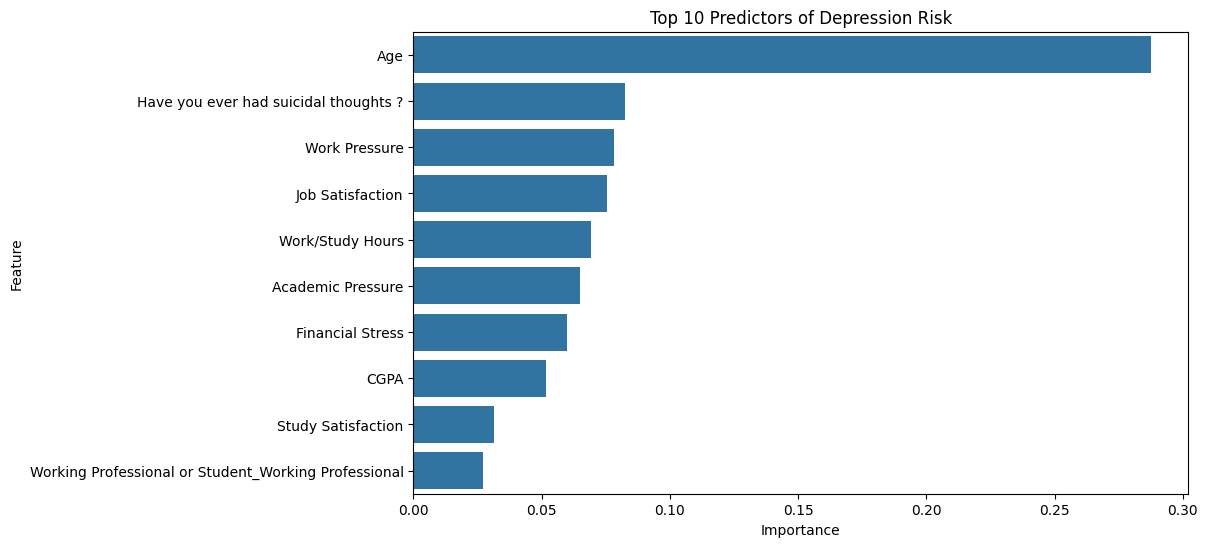

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

importances = pd.DataFrame({'Feature': X.columns, 'Importance': rf_model.feature_importances_})
importances = importances.sort_values(by='Importance', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importances)
plt.title('Top 10 Predictors of Depression Risk')
plt.show()

# **Save Model For Inference**

In [10]:
import joblib
import json

# 1. Save the Logistic Regression Pipeline
# (This includes the StandardScaler and the trained Model)
joblib.dump(lr_model, 'logistic_regression_pipeline.joblib')

# 2. Save the Random Forest Model
joblib.dump(rf_model, 'random_forest_model.joblib')

# 3. Save the Label Encoders
# (Crucial for transforming "Male/Female" or "Yes/No" back to the same integers)
joblib.dump(le, 'label_encoders.joblib')

# 4. Save Feature Metadata
# (Ensures the mobile app sends features in the correct order)
feature_metadata = {
    "feature_names": X.columns.tolist(),
    "target_mapping": {int(i): str(label) for i, label in enumerate(le.classes_)}
}

with open('feature_metadata.json', 'w') as f:
    json.dump(feature_metadata, f)

print("All model components saved successfully!")

All model components saved successfully!
